# Facial Expression Recognition (FER)

This project focuses on recognizing human emotions from facial images using machine learning.  
We use the FER-2013 dataset, which contains 48×48 grayscale images labeled with seven emotions: angry, disgust, fear, happy, neutral, sad, and surprise.  
The goal is to build and compare multiple neural network models to find the one that performs best on this classification task.



## Dataset Setup

This section downloads the dataset from Google Drive, extracts it, and checks the folder structure.  
If the files already exist, the download is skipped.


In [ ]:
# Install gdown
!pip install -q gdown

# Define the Google Drive file ID
file_id = "17dMZqWXtFcL7lIBLASqWwFe7HaJkm8rX"
zip_name = "face_expression_dataset.zip"
folder_name = "face_expression"

# Download the dataset (skip if already exists)
import os

if not os.path.exists(zip_name) and not os.path.exists(folder_name):
    print("⬇Downloading dataset from Google Drive...")
    !gdown {file_id} -O {zip_name}
else:
    print("Dataset ZIP or folder already exists, skipping download.")

# Unzip the dataset
if not os.path.exists(folder_name):
    print("🗜️ Extracting dataset...")
    !unzip -q {zip_name} -d {folder_name}
else:
    print("Dataset already extracted.")

# Fix redundant nested folders (auto-cleanup)
print("Checking and fixing nested folders (if any)...")
!if [ -d "face_expression/face_expression" ]; then \
      mv face_expression/face_expression/train face_expression/train; \
      mv face_expression/face_expression/validation face_expression/validation; \
      rm -rf face_expression/face_expression; \
      rm -rf face_expression/images; \
      echo "Folder structure cleaned."; \
  else \
      echo "Folder structure already clean."; \
  fi

# Verify final structure
print("Final dataset structure:")
!ls -R face_expression | head -40


Dataset ZIP or folder already exists, skipping download.
Dataset already extracted.
Checking and fixing nested folders (if any)...
Folder structure already clean.
Final dataset structure:
face_expression:
train
validation

face_expression/train:
angry
disgust
fear
happy
neutral
sad
surprise

face_expression/train/angry:
0.jpg
10002.jpg
10016.jpg
10037.jpg
10038.jpg
10057.jpg
10063.jpg
10069.jpg
10100.jpg
10105.jpg
10115.jpg
10122.jpg
10142.jpg
10154.jpg
10155.jpg
10158.jpg
1015.jpg
10167.jpg
1016.jpg
10178.jpg
10181.jpg
1018.jpg
10192.jpg
10196.jpg
10202.jpg
10207.jpg


In [ ]:
#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# The following line improves formatting when ouputting NumPy arrays.
np.set_printoptions(linewidth = 200)

In [ ]:
import tensorflow as tf

# Define paths
train_dir = "face_expression/train"
val_dir = "face_expression/validation"

# Create dataset loaders
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(48, 48),
    color_mode="grayscale",
    batch_size=32,
    label_mode="categorical"  # one-hot encoded labels
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(48, 48),
    color_mode="grayscale",
    batch_size=32,
    label_mode="categorical"
)


Found 28821 files belonging to 7 classes.
Found 7066 files belonging to 7 classes.


## Data Normalization

We normalize pixel values to the range [0, 1] for faster and more stable model training.  
The datasets are cached and prefetched to improve training performance.


In [ ]:
# Dataset Normalization

import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

# Save the class names BEFORE modifying the dataset
class_names = train_ds.class_names

# Normalize images (0–255 → 0–1)
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))

# Cache, shuffle, and prefetch (performance optimization)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


## Sample Visualization

This displays one sample image from the training set along with its label to confirm that data loading worked correctly.


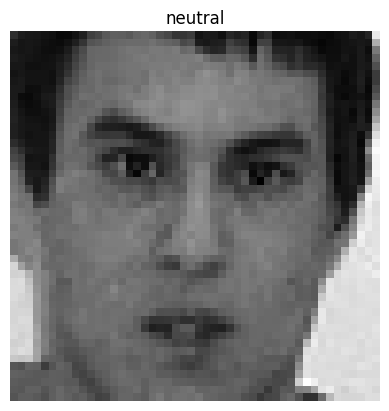

In [ ]:
# Output an example of the training set.
image, label = next(iter(train_ds))
plt.imshow(image[0].numpy().squeeze(), cmap='gray')
plt.title(class_names[tf.argmax(label[0]).numpy()])
plt.axis('off')
plt.show()


## Class Distribution

We count the number of images per emotion in the training set and plot a bar chart.  
This shows the imbalance between classes, such as more "happy" images compared to "disgust."


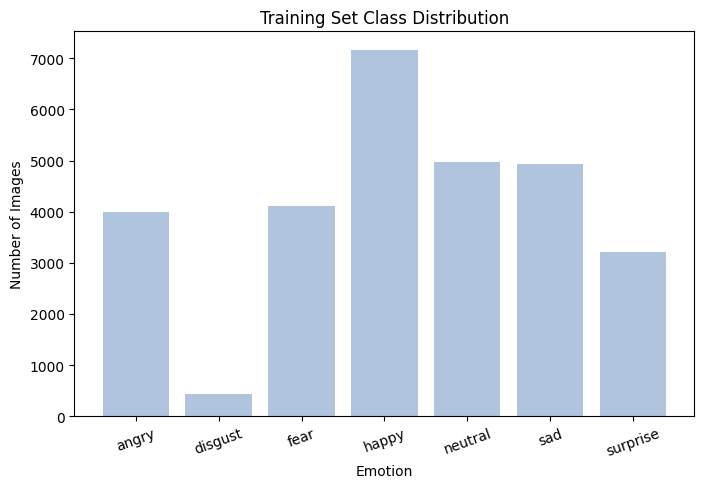

Class distribution (training set):
angry: 3993
disgust: 436
fear: 4103
happy: 7164
neutral: 4982
sad: 4938
surprise: 3205


In [ ]:
# --- Class Distribution Visualization ---

import os
import matplotlib.pyplot as plt

# Count images in each emotion folder (training set)
emotion_counts = {}
for emotion in os.listdir(train_dir):
    emotion_path = os.path.join(train_dir, emotion)
    if os.path.isdir(emotion_path):
        emotion_counts[emotion] = len(os.listdir(emotion_path))

# Sort emotions for consistency
emotion_counts = dict(sorted(emotion_counts.items()))

# Plot class distribution
plt.figure(figsize=(8,5))
plt.bar(emotion_counts.keys(), emotion_counts.values(), color='lightsteelblue')
plt.title("Training Set Class Distribution")
plt.xlabel("Emotion")
plt.ylabel("Number of Images")
plt.xticks(rotation=20)
plt.show()

print("Class distribution (training set):")
for emotion, count in emotion_counts.items():
    print(f"{emotion}: {count}")


In [ ]:
#@title Define the plotting function
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

Loaded the plot_curve function.


##Model 1: Baseline Neural Network

This baseline model is designed for facial expression classification.  
It consists of a simple feedforward architecture with one hidden dense layer and dropout for regularization.  
The model provides a foundation for testing deeper or more complex architectures later.

The `create_model()` function defines the following:
- **Input Layer:** Flattens each 48×48 grayscale image into a 1-D vector.  
- **Hidden Layer:** A dense layer with 64 ReLU-activated neurons to learn intermediate features.  
- **Regularization:** A dropout layer (rate = 0.3) to prevent overfitting.  
- **Output Layer:** A softmax layer with 7 neurons, one for each facial expression class  
  *(angry, disgust, fear, happy, neutral, sad, surprise).*  

The model is compiled with the Adam optimizer (custom learning rate),  
`categorical_crossentropy` loss (since labels are one-hot encoded),  
and accuracy as the evaluation metric.


In [ ]:
def create_model(my_learning_rate):
  """Create and compile a deep neural net for face expression classification."""

  model = tf.keras.models.Sequential()

  # Flatten 48x48 grayscale image into a 1D vector
  model.add(tf.keras.layers.Flatten(input_shape=(48, 48, 1)))

  # Hidden layer
  model.add(tf.keras.layers.Dense(units=64, activation='relu'))

  # Dropout regularization
  model.add(tf.keras.layers.Dropout(rate=0.3))

  # Output layer (7 classes: angry, disgust, fear, happy, neutral, sad, surprise)
  model.add(tf.keras.layers.Dense(units=7, activation='softmax'))

  # Compile model for multi-class classification
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
      loss="categorical_crossentropy",  # because labels are one-hot encoded
      metrics=['accuracy']
  )

  return model


def train_model(model, train_ds, val_ds, epochs):
  """Train the model using TensorFlow Datasets (not arrays)."""

  history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      shuffle=True
  )

  # Track training metrics
  epochs_ran = history.epoch
  hist = pd.DataFrame(history.history)
  return epochs_ran, hist


##Training and Evaluation

The model is trained for 50 epochs using the training dataset and validated on the validation set.  
During training, accuracy and loss are tracked for both sets to monitor learning progress and detect potential overfitting.  

After training, accuracy and loss curves are plotted to visualize model performance over time.  
Finally, the model is evaluated on the validation set (used here as a test set) to measure its final accuracy.

Run the following code cell to:
1. Define hyperparameters (learning rate and number of epochs).
2. Build the baseline neural network model.
3. Train the model using the prepared datasets.
4. Plot accuracy and loss curves.
5. Evaluate the trained model on the validation set.

*Note:* Training a convolution-free baseline on the facial expression dataset may take longer and achieve lower accuracy compared to simpler datasets such as MNIST, due to higher image complexity and class diversity.


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


901/901 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.2359 - loss: 1.9102 - val_accuracy: 0.2583 - val_loss: 1.8158
Epoch 2/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2478 - loss: 1.8135 - val_accuracy: 0.2583 - val_loss: 1.8091
Epoch 3/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2508 - loss: 1.8109 - val_accuracy: 0.2583 - val_loss: 1.8100
Epoch 4/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2485 - loss: 1.8106 - val_accuracy: 0.2586 - val_loss: 1.8090
Epoch 5/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2492 - loss: 1.8094 - val_accuracy: 0.2586 - val_loss: 1.8095
Epoch 6/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2485 - loss: 1.8143 - val_accuracy: 0.2586 - val_loss: 1.8087
Epoch 7/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2527 - loss: 1.8088 - val_accuracy: 0.2586 - val_loss: 1.8096
Epoch 8/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2525 - loss: 1.8086 - val_accuracy: 0.2586 - val_

[1.8092788457870483, 0.25870364904403687]

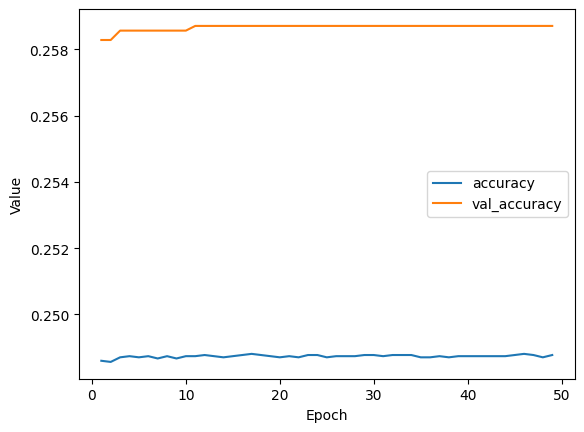

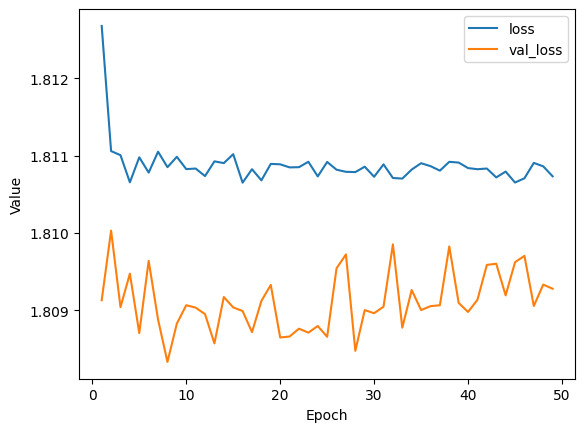

In [ ]:
# Hyperparameters
learning_rate = 0.003
epochs = 50

# Build the model
my_model = create_model(learning_rate)

# Train the model on the dataset
epochs_ran, hist = train_model(my_model, train_ds, val_ds, epochs)

# Plot accuracy and loss curves
plot_curve(epochs_ran, hist, ['accuracy', 'val_accuracy'])
plot_curve(epochs_ran, hist, ['loss', 'val_loss'])

# Evaluate against the validation set (acts as test set here)
print("\n🧪 Evaluate the new model against the validation set:")
my_model.evaluate(val_ds)


## Optimize the Model

In this task, we improve upon the baseline network by experimenting with a deeper architecture and adjusted regularization.

The new model introduces:
- **Two hidden layers**:
  - First hidden layer: 256 ReLU neurons
  - Second hidden layer: 128 ReLU neurons
- **Dropout regularization:** 0.3 after each hidden layer to reduce overfitting
- **Output layer:** 7 neurons with softmax activation for the emotion classes

The model is trained for 50 epochs with a learning rate of 0.001, and its accuracy and loss curves are plotted to visualize learning behavior.

Finally, the model’s performance is evaluated on the validation set and compared with the baseline model to assess improvements.


Epoch 1/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.2342 - loss: 1.8855 - val_accuracy: 0.2583 - val_loss: 1.8067
Epoch 2/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2499 - loss: 1.8096 - val_accuracy: 0.2583 - val_loss: 1.8096
Epoch 3/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2493 - loss: 1.8114 - val_accuracy: 0.2583 - val_loss: 1.8062
Epoch 4/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2489 - loss: 1.8084 - val_accuracy: 0.2583 - val_loss: 1.8084
Epoch 5/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2499 - loss: 1.8089 - val_accuracy: 0.2583 - val_loss: 1.8107
Epoch 6/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2474 - loss: 1.8137 - val_accuracy: 0.2583 - val_loss: 1.8091
Epoch 7/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2469 - loss: 1.8160 - val_accuracy: 0.2583 - val_loss: 1.8092
Epoch 8/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2523 - loss: 1.8098 - val_accuracy: 0.

[1.7512375116348267, 0.2602604031562805]

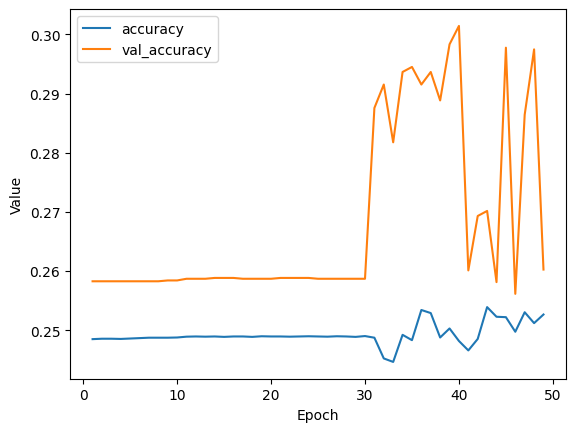

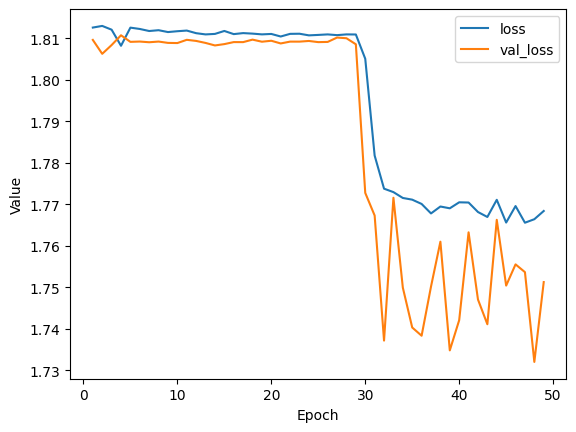

In [ ]:

# optimizing the model


def create_model_1(my_learning_rate=0.001):
  """Create and compile a tuned baseline neural net for facial expression classification."""

  model = tf.keras.models.Sequential()

  # Flatten 48x48 grayscale image into 1D vector
  model.add(tf.keras.layers.Flatten(input_shape=(48, 48, 1)))

  # First hidden layer
  model.add(tf.keras.layers.Dense(units=256, activation='relu'))
  model.add(tf.keras.layers.Dropout(rate=0.3))   # lighter regularization

  # Second hidden layer (new)
  model.add(tf.keras.layers.Dense(units=128, activation='relu'))
  model.add(tf.keras.layers.Dropout(rate=0.3))

  # Output layer: 7 emotion classes
  model.add(tf.keras.layers.Dense(units=7, activation='softmax'))

  # Compile the model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
      loss="categorical_crossentropy",   # one-hot labels
      metrics=['accuracy']
  )

  return model


def train_model_1(model, train_ds, val_ds, epochs):
  """Train the model using TensorFlow Datasets."""

  history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      shuffle=True
  )

  # Collect metrics per epoch
  epochs_ran = history.epoch
  hist = pd.DataFrame(history.history)
  return epochs_ran, hist


#training

learning_rate = 0.001
epochs = 50

# Build and train the model
my_model = create_model_1(learning_rate)
epochs_ran, hist = train_model_1(my_model, train_ds, val_ds, epochs)

# Plot training curves
plot_curve(epochs_ran, hist, ['accuracy', 'val_accuracy'])
plot_curve(epochs_ran, hist, ['loss', 'val_loss'])

# Evaluate on validation (acts as test set)
print("Evaluate the improved model on the validation set:")
my_model.evaluate(val_ds)


## Hyperparameter Tuning

Here we use GridSearchCV to test different model settings such as dropout, number of neurons, and epochs.  
The best parameters are printed, then we train a final model using them.  
Finally, we plot accuracy and show the confusion matrix and classification report to check performance.


In [ ]:
!pip install scikeras


In [ ]:
#!pip install scikit-learn==1.4.2

In [ ]:
import numpy as np
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt


In [ ]:
# ================================
# PART A — Hyperparameter Tuning (no need to run this code again!!)
# ================================

X_train = []
y_train = []
for images, labels in train_ds:
    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())

X_train = np.array(X_train)
y_train = np.array(y_train)

def build_nn_model(optimizer='adam', dropout_rate=0.3, neurons=128):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(48,48,1)))
    model.add(tf.keras.layers.Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(7, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=build_nn_model, verbose=0)

param_grid = {
    'model__optimizer': ['adam', 'rmsprop'],
    'model__dropout_rate': [0.2, 0.3, 0.5],
    'model__neurons': [64, 128],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

print("Best Parameters:", grid_result.best_params_)
print("Best Accuracy:", grid_result.best_score_)

/usr/local/lib/python3.12/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as t

Best Parameters: {'batch_size': 64, 'epochs': 20, 'model__dropout_rate': 0.3, 'model__neurons': 128, 'model__optimizer': 'rmsprop'}
Best Accuracy: 0.3461018007702717


Epoch 1/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.2178 - loss: 2.1723 - val_accuracy: 0.2494 - val_loss: 1.9305
Epoch 2/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2653 - loss: 1.7900 - val_accuracy: 0.2808 - val_loss: 1.7531
Epoch 3/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2871 - loss: 1.7639 - val_accuracy: 0.3070 - val_loss: 1.7240
Epoch 4/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2905 - loss: 1.7532 - val_accuracy: 0.3056 - val_loss: 1.7351
Epoch 5/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3010 - loss: 1.7328 - val_accuracy: 0.3141 - val_loss: 1.7265
Epoch 6/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3022 - loss: 1.7201 - val_accuracy: 0.3193 - val_loss: 1.7229
Epoch 7/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3036 - loss: 1.7164 - val_accuracy: 0.3268 - val_loss: 1.7087
Epoch 8/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3019 - loss: 1.7194 - val_accuracy: 0.

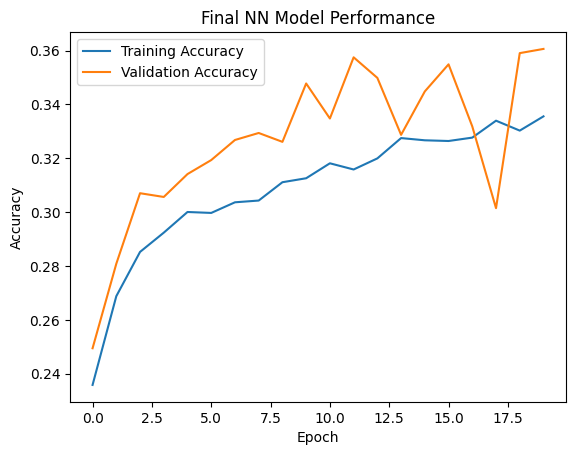

In [ ]:
# ================================
# PART B — Final NN Model (best parameters)
# ================================

# Use best params you copied from GridSearch
best_optimizer = 'rmsprop'
best_dropout = 0.3
best_neurons = 128
best_batch = 64
best_epochs = 20

# Build model using the best hyperparameters
final_nn_model = build_nn_model(
    optimizer=best_optimizer,
    dropout_rate=best_dropout,
    neurons=best_neurons
)

# Train final model
history = final_nn_model.fit(
    X_train, y_train,
    epochs=best_epochs,
    batch_size=best_batch,
    validation_split=0.2
)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Final NN Model Performance')
plt.show()


# Model 2: Convolutional Neural Network (CNN)


Build CNN Model


In [ ]:
# =======================
# Model 2: Convolutional Neural Network (CNN)
# =======================

def create_cnn_model(learning_rate=0.001, use_dropout=True):

    model = tf.keras.models.Sequential()

    # --- Block 1 ---
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(48,48,1)))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    if use_dropout:
        model.add(tf.keras.layers.Dropout(0.25))

    # --- Block 2 ---
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    if use_dropout:
        model.add(tf.keras.layers.Dropout(0.25))

    # --- Block 3 ---
    model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    if use_dropout:
        model.add(tf.keras.layers.Dropout(0.4))

    # --- Fully Connected ---
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    if use_dropout:
        model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(7, activation='softmax'))  # 7 classes

    # --- Compile the model ---
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


Train the CNN Model

In [ ]:
# =======================
# Train CNN model
# =======================

def train_cnn_model(model, train_ds, val_ds, epochs):
    """Train CNN model using TensorFlow Datasets."""
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=1
    )
    epochs_range = range(epochs)
    hist = pd.DataFrame(history.history)
    return epochs_range, hist

# --- Training setup ---
learning_rate = 0.001
epochs = 30

cnn_model = create_cnn_model(learning_rate, use_dropout=True)
epochs_range, hist = train_cnn_model(cnn_model, train_ds, val_ds, epochs)


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


901/901 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.2580 - loss: 1.7994 - val_accuracy: 0.3886 - val_loss: 1.5854
Epoch 2/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3801 - loss: 1.5797 - val_accuracy: 0.4591 - val_loss: 1.4320
Epoch 3/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4340 - loss: 1.4631 - val_accuracy: 0.4836 - val_loss: 1.3425
Epoch 4/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4628 - loss: 1.3959 - val_accuracy: 0.5069 - val_loss: 1.2951
Epoch 5/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4838 - loss: 1.3560 - val_accuracy: 0.5275 - val_loss: 1.2630
Epoch 6/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4974 - loss: 1.3170 - val_accuracy: 0.5297 - val_loss: 1.2284
Epoch 7/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5109 - loss: 1.2821 - val_accuracy: 0.5391 - val_loss: 1.2154
Epoch 8/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5180 - loss: 1.2601 - val_accuracy: 0.5276 - va

In [ ]:
# =======================
# Evaluate the model
# =======================

print("\nEvaluating CNN model on validation set:")
cnn_eval = cnn_model.evaluate(val_ds)

print(f"\nValidation Accuracy: {cnn_eval[1]*100:.2f}%")
print(f"Validation Loss: {cnn_eval[0]:.4f}")



Evaluating CNN model on validation set:
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5916 - loss: 1.0989

Validation Accuracy: 59.71%
Validation Loss: 1.1003


#Enhanced CNN


Our original CNN got 60% accuracy, which is okay but not great. We're improving it by:
1. Making it DEEPER (more layers = learns more complex patterns)
2. Adding Batch Normalization (makes training faster and more stable)
3. Using Global Average Pooling (reduces overfitting better than Flatten)
4. Using a better optimizer (AdamW instead of Adam)


In [ ]:
# =======================
# Enhanced CNN
# =======================
def create_enhanced_cnn(learning_rate=0.0001, use_batch_norm=True):
    """
    Enhanced CNN with:
    - Batch Normalization
    - Deeper architecture
    - Residual-like connections
    - Better regularization
    """
    inputs = tf.keras.layers.Input(shape=(48, 48, 1))

    # --- Block 1 ---
    x = tf.keras.layers.Conv2D(64, (3,3), padding='same')(inputs)
    if use_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(64, (3,3), padding='same')(x)
    if use_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    # --- Block 2 ---
    x = tf.keras.layers.Conv2D(128, (3,3), padding='same')(x)
    if use_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(128, (3,3), padding='same')(x)
    if use_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    # --- Block 3 ---
    x = tf.keras.layers.Conv2D(256, (3,3), padding='same')(x)
    if use_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(256, (3,3), padding='same')(x)
    if use_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    # --- Block 4 (Additional depth) ---
    x = tf.keras.layers.Conv2D(512, (3,3), padding='same')(x)
    if use_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(512, (3,3), padding='same')(x)
    if use_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # --- Global Average Pooling (better than Flatten) ---
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # --- Dense Layers ---
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    # --- Output ---
    outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    # Use AdamW optimizer (better than Adam)
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

#VGG Fine-tuning
we changed the followeing to fit our data with the VGG constraints
1. Convert grayscale → RGB by copying the same image 3 times
2. Resize 48x48 → 224x224
3. Freeze early layers (keep VGG's learned features)
4. Train only the last layers to recognize emotions


In [ ]:

# =======================
# VGG-16 Fine-Tuning
# =======================
def create_vgg16_finetuned(learning_rate=0.0001, freeze_layers=15):
    """
    VGG-16 fine-tuning adapted for grayscale images.
    Key fix: Convert grayscale to RGB by repeating channels.
    """
    # Input layer for grayscale
    inputs = tf.keras.layers.Input(shape=(48, 48, 1))

    # Convert grayscale to RGB (repeat channel 3 times)
    x = tf.keras.layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1))(inputs)

    # Resize to VGG input size (224x224)
    x = tf.keras.layers.Resizing(224, 224)(x)

    # Load pre-trained VGG-16 (without top layers)
    base_model = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False,
        input_tensor=x
    )

    # Freeze early layers
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False

    # Add custom top layers
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


#Callbacks
Our original training just ran for 30 epochs and stopped, regardless of performance.
Callbacks make training SMARTER by automatically:
1. Reducing learning rate when stuck
2. Stopping early if not improving (saves time)
3. Saving the best model (not the last one)

In [ ]:

# =======================
# Training with Advanced Callbacks
# =======================
def train_with_callbacks(model, train_ds, val_ds, epochs, model_name):
    """Train with learning rate scheduling and early stopping."""

    # Callbacks
    callbacks = [
        # Reduce learning rate when validation loss plateaus
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        # Early stopping
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=8,
            restore_best_weights=True,
            verbose=1
        ),
        # Save best model
        tf.keras.callbacks.ModelCheckpoint(
            f'{model_name}_best.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return history


# TRAINING  MODELS
We'll train two extra different models and compare them:
1. Enhanced CNN - Our improved version with deeper architecture
2. VGG-16 Fine-tuned


In [ ]:
# =======================
# TRAINING SECTION
# =======================

# Enhanced CNN
print("=" * 50)
print("Training Enhanced CNN Model")
print("=" * 50)
enhanced_cnn = create_enhanced_cnn(learning_rate=0.0001, use_batch_norm=True)
enhanced_cnn.summary()

history_enhanced = train_with_callbacks(
    enhanced_cnn,
    train_ds,
    val_ds,
    epochs=50,
    model_name='enhanced_cnn'
)

Training Enhanced CNN Model


Model: "functional_704"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_174 (InputLayer)    │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_183 (Dropout)           │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_184 (Dropout)           │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 5,087,687 (19.41 MB)

 Trainable params: 5,083,847 (19.39 MB)

 Non-trainable params: 3,840 (15.00 KB)

Epoch 1/50
900/901 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2083 - loss: 1.9795
Epoch 1: val_accuracy improved from -inf to 0.25842, saving model to enhanced_cnn_best.keras
901/901 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.2083 - loss: 1.9793 - val_accuracy: 0.2584 - val_loss: 1.8249 - learning_rate: 1.0000e-04
Epoch 2/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2656 - loss: 1.7744
Epoch 2: val_accuracy improved from 0.25842 to 0.32904, saving model to enhanced_cnn_best.keras
901/901 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.2656 - loss: 1.7743 - val_accuracy: 0.3290 - val_loss: 1.6584 - learning_rate: 1.0000e-04
Epoch 3/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3556 - loss: 1.6125
Epoch 3: val_accuracy improved from 0.32904 to 0.41933, saving model to enhanced_cnn_best.keras
901/901 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.3556 - loss: 1.6124 - val_accuracy: 0.4193 - val_loss: 1.4960 - learning_rate: 1.0000e-04
Epoch 4/50
90

In [ ]:
# VGG-16 Fine-tuning
print("\n" + "=" * 50)
print("Training VGG-16 Fine-tuned Model")
print("=" * 50)
vgg_model = create_vgg16_finetuned(learning_rate=0.0001, freeze_layers=15)
vgg_model.summary()

history_vgg = train_with_callbacks(
    vgg_model,
    train_ds,
    val_ds,
    epochs=50,
    model_name='vgg16_finetuned'
)



Training VGG-16 Fine-tuned Model
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_705"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_175 (InputLayer)    │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_353 (Dense)               │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_189 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,110,471 (57.64 MB)

 Trainable params: 9,835,015 (37.52 MB)

 Non-trainable params: 5,275,456 (20.12 MB)

Epoch 1/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.2825 - loss: 1.7477
Epoch 1: val_accuracy improved from -inf to 0.51953, saving model to vgg16_finetuned_best.keras
901/901 ━━━━━━━━━━━━━━━━━━━━ 302s 304ms/step - accuracy: 0.2826 - loss: 1.7475 - val_accuracy: 0.5195 - val_loss: 1.2770 - learning_rate: 1.0000e-04
Epoch 2/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.5213 - loss: 1.2734
Epoch 2: val_accuracy improved from 0.51953 to 0.55859, saving model to vgg16_finetuned_best.keras
901/901 ━━━━━━━━━━━━━━━━━━━━ 243s 270ms/step - accuracy: 0.5214 - loss: 1.2733 - val_accuracy: 0.5586 - val_loss: 1.1732 - learning_rate: 1.0000e-04
Epoch 3/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.5784 - loss: 1.1096
Epoch 3: val_accuracy improved from 0.55859 to 0.57755, saving model to vgg16_finetuned_best.keras
901/901 ━━━━━━━━━━━━━━━━━━━━ 243s 270ms/step - accuracy: 0.5784 - loss: 1.1096 - val_accuracy: 0.5776 - val_loss: 1.1050 - learning_rate: 1.0000

#Plot Models Comparison

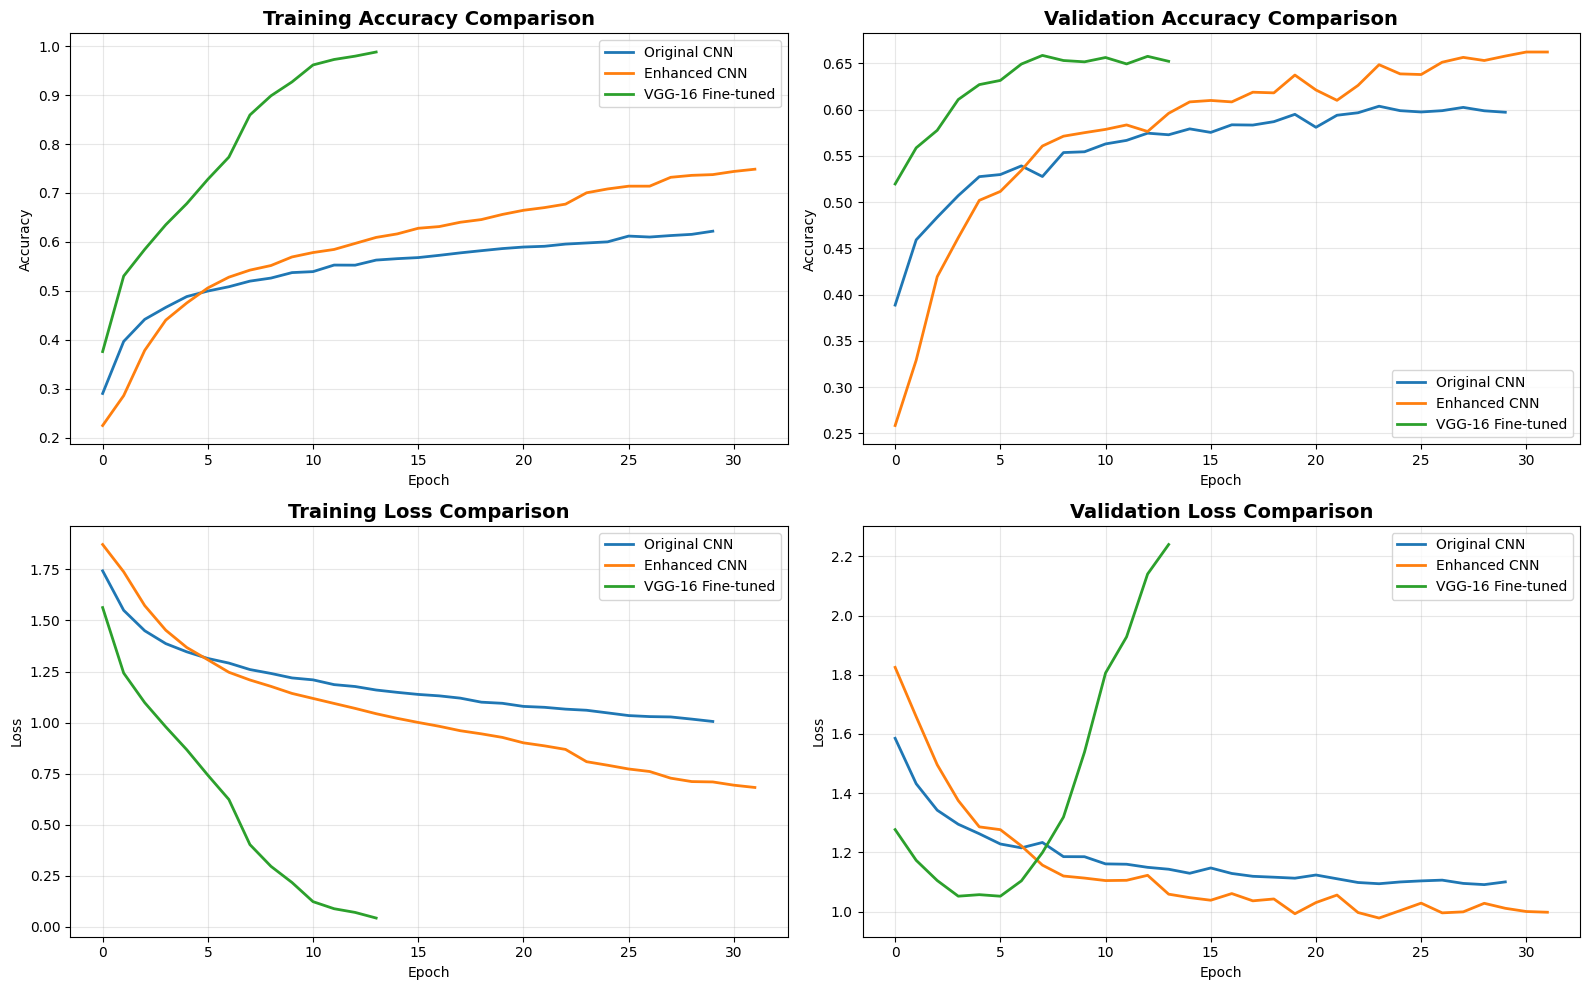


FINAL RESULTS SUMMARY

Original CNN:
  Final Train Accuracy: 0.6218
  Final Val Accuracy: 0.5971
  Best Val Accuracy: 0.6036

Enhanced CNN:
  Final Train Accuracy: 0.7485
  Final Val Accuracy: 0.6622
  Best Val Accuracy: 0.6622

VGG-16 Fine-tuned:
  Final Train Accuracy: 0.9881
  Final Val Accuracy: 0.6521
  Best Val Accuracy: 0.6585


In [ ]:

# Plot All Models Comparison

plt.figure(figsize=(16, 10))

# Collect model histories for comparison (only 3 models)
models_history = {
    'Original CNN': hist,
    'Enhanced CNN': pd.DataFrame(history_enhanced.history),
    'VGG-16 Fine-tuned': pd.DataFrame(history_vgg.history)
}

# --- Plot 1: Training Accuracy
# Shows how well each model learned from training data
plt.subplot(2, 2, 1)
for name, h in models_history.items():
    plt.plot(h['accuracy'], label=name, linewidth=2)
plt.title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# --- Plot 2: Validation Accuracy
# Shows how well each model works on unseen data
plt.subplot(2, 2, 2)
for name, h in models_history.items():
    plt.plot(h['val_accuracy'], label=name, linewidth=2)
plt.title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# --- Plot 3: Training Loss
plt.subplot(2, 2, 3)
for name, h in models_history.items():
    plt.plot(h['loss'], label=name, linewidth=2)
plt.title('Training Loss Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# --- Plot 4: Validation Loss
plt.subplot(2, 2, 4)
for name, h in models_history.items():
    plt.plot(h['val_loss'], label=name, linewidth=2)
plt.title('Validation Loss Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print Final Results Summary

print("\n" + "=" * 50)
print("FINAL RESULTS SUMMARY")
print("=" * 50)
for name, h in models_history.items():
    final_train_acc = h['accuracy'].iloc[-1]
    final_val_acc = h['val_accuracy'].iloc[-1]
    best_val_acc = h['val_accuracy'].max()
    overfitting_gap = final_train_acc - final_val_acc

    print(f"\n{name}:")
    print(f"  Final Train Accuracy: {final_train_acc:.4f}")
    print(f"  Final Val Accuracy: {final_val_acc:.4f}")
    print(f"  Best Val Accuracy: {best_val_acc:.4f}")



In [ ]:
# ADD CONFUSION MATRICES RIGHT HERE
# =======================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def generate_confusion_matrix(model, model_name, dataset=val_ds):
    # ... the confusion matrix code ...

# Generate the confusion matrices
print("\n" + "=" * 60)
print("GENERATING CONFUSION MATRICES")
print("=" * 60)

print("\n1. Baseline Neural Network Confusion Matrix:")
cm_nn = generate_confusion_matrix(my_model, "Baseline NN")

print("\n2. Original CNN Confusion Matrix:")
cm_cnn = generate_confusion_matrix(cnn_model, "Original CNN")

print("\n3. Enhanced CNN Confusion Matrix:")
cm_enhanced = generate_confusion_matrix(enhanced_cnn, "Enhanced CNN")

print("\n4. VGG-16 Fine-tuned Confusion Matrix:")
cm_vgg = generate_confusion_matrix(vgg_model, "VGG-16 Fine-tuned")


##live demo section

In [ ]:
# =======================================
# Save All 3 Final Models
# =======================================

print("Saving all models...")

# 1. Tuned Neural Network
final_nn_model.save("nn_tuned_model.keras")

# 2. Enhanced CNN
enhanced_cnn.save("enhanced_cnn_model.keras")

# 3. Fine-tuned VGG16
vgg_model.save("vgg16_finetuned_model.keras")

print("All models saved successfully!")

Saving all models...
All models saved successfully!


In [ ]:
def create_vgg16_finetuned(learning_rate=0.0001, freeze_layers=15):

    inputs = tf.keras.Input(shape=(224,224,3))  # RGB input

    base_model = tf.keras.applications.VGG16(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs
    )

    # Freeze layers
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False

    # Custom top layers
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    return model


In [ ]:
import numpy as np
import cv2
import keras
from keras.models import load_model

# allow lambda deserialization for NN/CNN
keras.config.enable_unsafe_deserialization()

# -----------------------------
# Load models
# -----------------------------
nn_model = load_model("nn_tuned_model.keras", compile=False, safe_mode=False)
enhanced_cnn_model = load_model("enhanced_cnn_model.keras", compile=False, safe_mode=False)

# Load VGG: rebuild architecture then load weights
vgg_model_loaded = create_vgg16_finetuned()
vgg_model_loaded.load_weights("vgg16_finetuned_best.keras")


# -----------------------------
# FER Classes
# -----------------------------
class_names = ['angry','disgust','fear','happy','sad','surprise','neutral']


# -----------------------------
# PREPROCESSING FUNCTIONS
# -----------------------------

# For NN and Enhanced CNN (expect 48×48 grayscale)
def preprocess_gray_48(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (48,48))
    img = img / 255.0
    img = img.reshape(1,48,48,1)
    return img

# For VGG (expects 224×224×3 RGB)
def preprocess_vgg(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = img / 255.0
    img = img.reshape(1,224,224,3)
    return img


test_images = [
    "angry.jpg",
    "disgust.jpg",
    "fear.jpg",
    "happy.jpg",
    "neutral.jpg",
    "sad.jpg",
    "surprise.jpg"
]

true_labels = [
    "angry",
    "disgust",
    "fear",
    "happy",
    "neutral",
    "sad",
    "surprise"
]


# -----------------------------
# Test model helper
# -----------------------------
def test_model(model, name, preprocess_fn):
    print(f"\n=== Testing {name} ===")
    for img, truth in zip(test_images, true_labels):
        x = preprocess_fn(img)
        pred = model.predict(x, verbose=0)
        pred_label = class_names[np.argmax(pred)]
        print(f"Image: {img:<20} | Prediction: {pred_label:<10} | Truth: {truth}")


# -----------------------------
# RUN TESTING
# -----------------------------
test_model(nn_model, "NN Model", preprocess_gray_48)
test_model(enhanced_cnn_model, "Enhanced CNN", preprocess_gray_48)
test_model(vgg_model_loaded, "VGG16 Fine-Tuned", preprocess_vgg)



=== Testing NN Model ===
Image: angry.jpg            | Prediction: sad        | Truth: angry
Image: disgust.jpg          | Prediction: happy      | Truth: disgust
Image: fear.jpg             | Prediction: surprise   | Truth: fear
Image: happy.jpg            | Prediction: happy      | Truth: happy
Image: neutral.jpg          | Prediction: happy      | Truth: neutral
Image: sad.jpg              | Prediction: sad        | Truth: sad
Image: surprise.jpg         | Prediction: sad        | Truth: surprise

=== Testing Enhanced CNN ===
Image: angry.jpg            | Prediction: angry      | Truth: angry
Image: disgust.jpg          | Prediction: disgust    | Truth: disgust
Image: fear.jpg             | Prediction: sad        | Truth: fear
Image: happy.jpg            | Prediction: happy      | Truth: happy
Image: neutral.jpg          | Prediction: sad        | Truth: neutral
Image: sad.jpg              | Prediction: angry      | Truth: sad
Image: surprise.jpg         | Prediction: neutral    | 


=== Visualizing NN Model ===


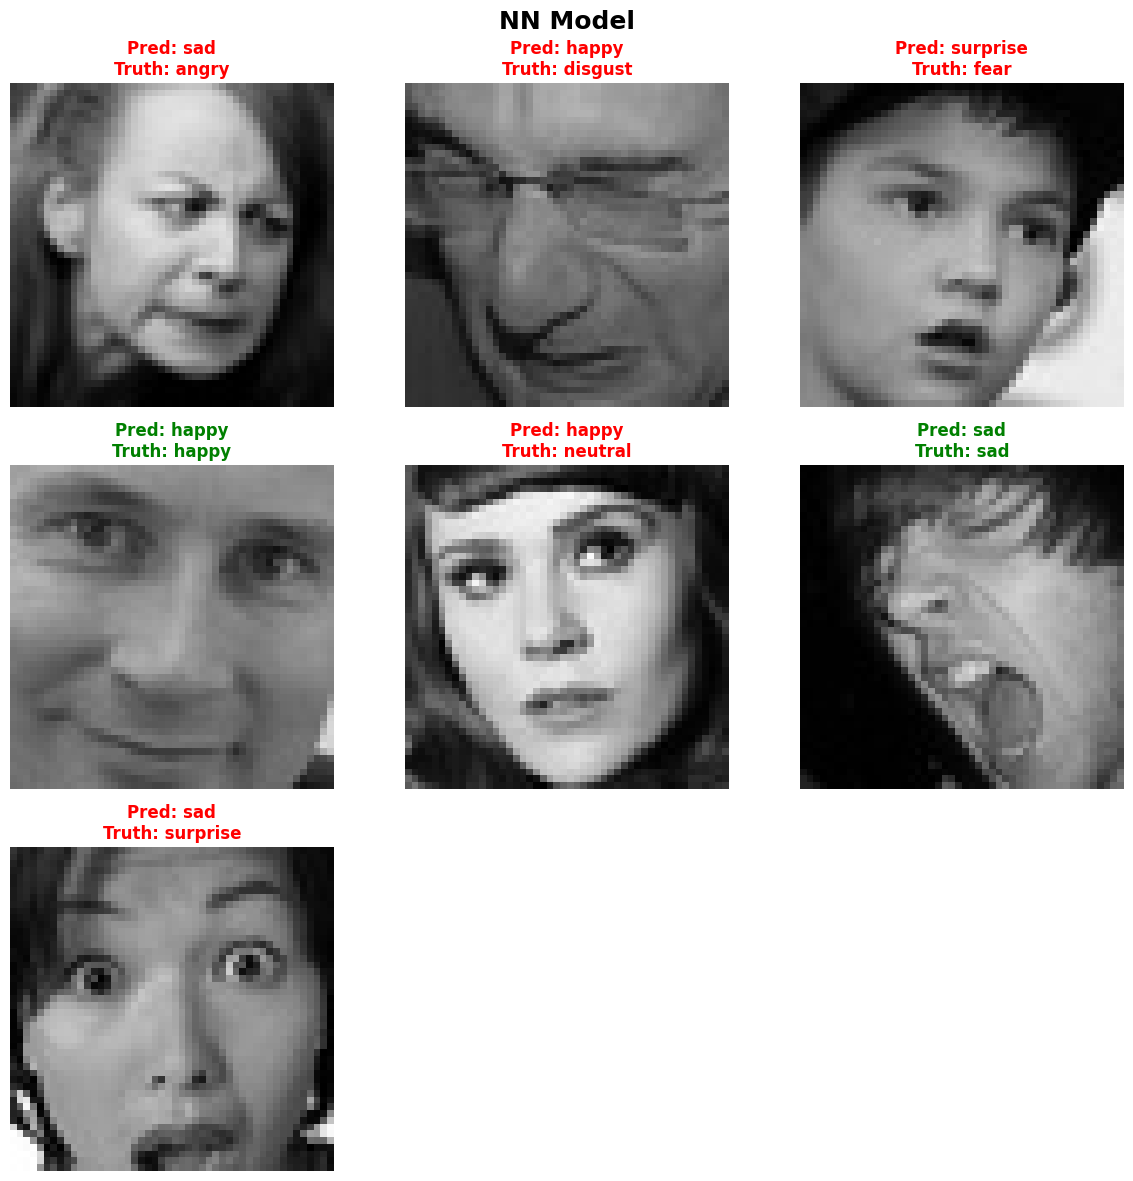


=== Visualizing Enhanced CNN ===


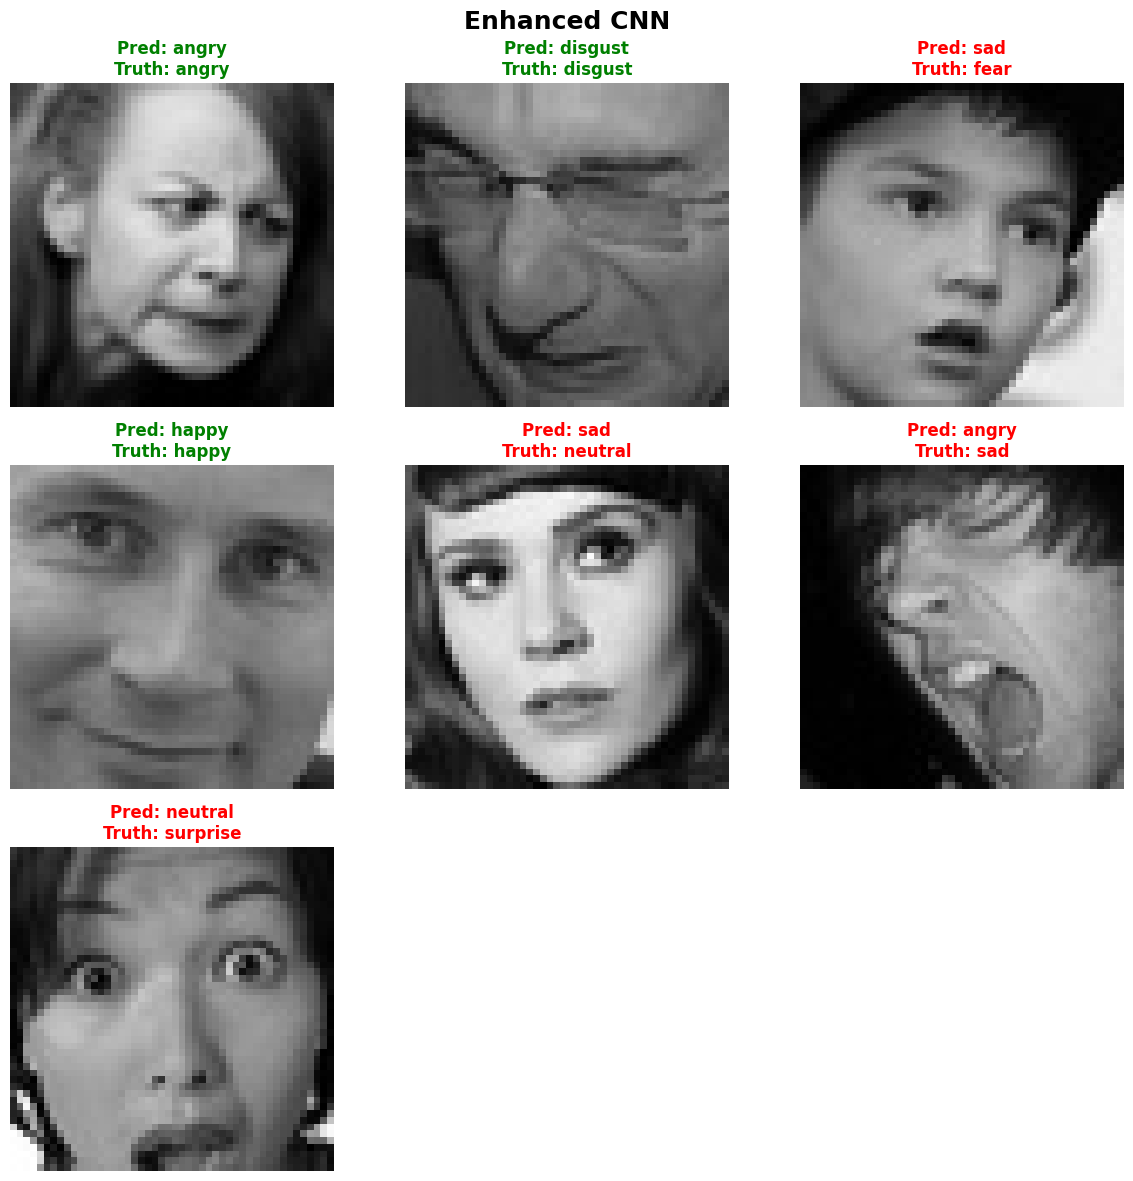


=== Visualizing VGG16 Fine-Tuned ===


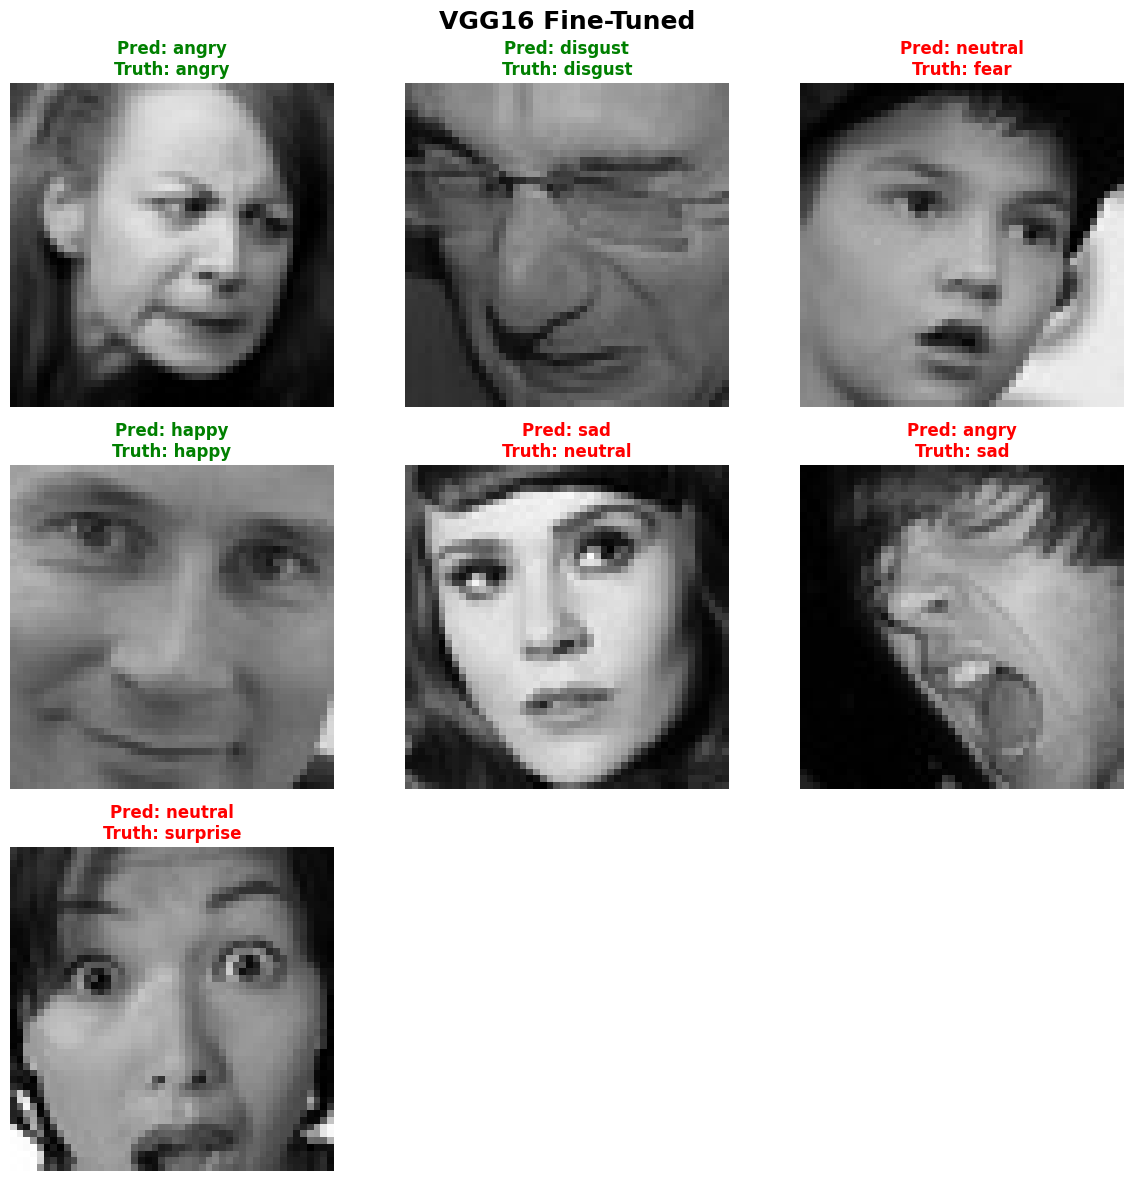

In [ ]:
import math
import matplotlib.pyplot as plt

def visualize_model_results(model, name, preprocess_fn):
    print(f"\n=== Visualizing {name} ===")

    num_images = len(test_images)
    cols = 3                              # 3 images per row
    rows = math.ceil(num_images / cols)   # auto rows

    plt.figure(figsize=(cols * 4, rows * 4))

    for i, (img_path, truth) in enumerate(zip(test_images, true_labels)):
        x = preprocess_fn(img_path)
        pred = model.predict(x, verbose=0)
        pred_label = class_names[np.argmax(pred)]

        img_disp = cv2.imread(img_path)
        img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)

        color = "green" if pred_label == truth else "red"

        # dynamic subplot
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img_disp)
        plt.axis("off")
        plt.title(
            f"Pred: {pred_label}\nTruth: {truth}",
            color=color,
            fontsize=12,
            fontweight="bold"
        )

    plt.suptitle(name, fontsize=18, fontweight="bold")
    plt.tight_layout()
    plt.show()

# Run visualizations
visualize_model_results(nn_model, "NN Model", preprocess_gray_48)
visualize_model_results(enhanced_cnn_model, "Enhanced CNN", preprocess_gray_48)
visualize_model_results(vgg_model_loaded, "VGG16 Fine-Tuned", preprocess_vgg)

